# Neuronal Network Dynamics Tutorial Part 1: The Wilson-Cowan Model

## Background
The brain is a complex system not because it is composed of a large number of diverse types of neurons but mainly because of the networks of those neurons. Essentially the brain is a network of highly specialized networks. 

The network of neurons can be studied from the perspective of information processing (e.g. as we also do in ANNs). At the same time by virtue of their connectivity biologocial neuronal network are also dynamical systems and exhibit many interesting phenomenon. How dynamics of neuronal networks affect representation and processing of information in the brain is an open question. But we see signatures of altered brain dynamics many brain diseases e.g. Epilepsy, Parkinson's disease etc. 

In this tutorial we will simulate and study one of the simplest models of biological neuonal networks. Instead of modelling and simulating individual excitatory and inihibitory neurons, we will treat them as two populations of excitatory and inhibitory neurons and study the dynamics of their rates. Such models are called the firing rate-based models. In this tutorial you will work with a single population of excitatory neurons. In the next tutorial we will add the inhibitory population to the network.

## Objectives
We are going to simulate a neural rate model of a single population of excitatory neurons and use it to study the following: 

- What are the different steady states of the neural rate model. We will find out the parameters for each of these states. 

To understand the dynamics of the following neural rate model, we will find the **fixed point**, and investigate the corresponding **stability** of the fixed point after linearizing the dynamics 

The neural rate model of the single population of excitatory neurons discussed in the tutorial is reduced by **Wilson-Cowan** rate model which will be introduced in the next tutorial.


Please execute the cell below to initialize the notebook environment.

In [1]:
#@title  Imports

import matplotlib.pyplot as plt    # import matplotlib
import numpy as np                 # import numpy
import scipy.optimize as opt       # import root-finding algorithm
import ipywidgets as widgets       # interactive display

fig_w, fig_h = 6, 4
my_fontsize = 16
my_params = {'axes.labelsize': my_fontsize,
          'axes.titlesize': my_fontsize,
          'figure.figsize': [fig_w, fig_h],
          'font.size': my_fontsize,
          'legend.fontsize': my_fontsize-4,
          'lines.markersize': 8.,
          'lines.linewidth': 2.,
          'xtick.labelsize': my_fontsize-2,
          'ytick.labelsize': my_fontsize-2}

plt.rcParams.update(my_params)

Individual neurons respond by spiking. When we average the spikes of neurons in a population, we can define average firing activity of the population. In this model we are interested in how the population-averaged firing varies as a function of different network parameters. 

## Dynamics of a single excitatory population

\begin{align}
\tau_E \frac{dE}{dt} &= -E + F(w_{EE}E + I^{\text{ext}}_E)  \quad\qquad (1)
\end{align}

$E(t)$ represents the average firing rate of the excitatory population, $\tau_E$ controls the timescale, $w_{EE}$ denotes the strength of recurrent inputs from other excitatory neurons in the population, $I^{\text{ext}}_E$ represents the external input to the excitatory population, and the function $F(\cdot)$ is a non-linear function that represents the population activation function (loosely equivalent to f-I curve of individual neurons).


To start, execute the cell below to initialize the simulation parameters.

In [2]:
#@title Default parameters for single excitatory population model
def default_parsE( **kwargs):
    pars = {}
    
    ### Excitatory parameters ###
    pars['tau_E']   = 1.    # Timescale of the E population [ms]
    pars['a_E']     = 1.2   # Gain of the E population
    pars['theta_E'] = 2.8   # Threshold of the E population

    ### Connection strength ###
    pars['wEE'] = 0. # E to E, we first set it to 0

    ### External input ###
    pars['I_ext_E']  = 0.

    ### simulation parameters ###
    pars['T'] = 20. # Total duration of simulation [ms]
    pars['dt'] = .1  # Simulation time step [ms]
    pars['E_init'] = 0.2 # Initial value of E
    
    ### External parameters if any ###
    for k in kwargs:
        pars[k] = kwargs[k]
        
    pars['range_t'] = np.arange(0, pars['T'], pars['dt']) # Vector of discretized time points [ms]
          
    return pars

You can use `pars = default_parsE()` to get all the parameters, and you then can use `print(pars)` to check these parameters. 
- `pars = default_parsE(T=T_sim, dt=time_step)` to set new simulation time and time step
- After `pars = default_parsE()`, use `pars['New_para'] = value` to add an new parameter with its value

## F-I curves
In electrophysiology, a neuron is often characterized by its spike rate output in response to a current input. This is often called the **F-I** curve, as frequency response (F) to different injected current (I) -- we estimated this for an LIF neuron in the previosu tutorial.

In the Wilson-Cowan model, $F(\cdot)$ is assumed to be a sigmoidal function, i.e. more drive leads a neuron to increase its output firing rate, but this output firing rate is saturating. 

$F(\cdot)$ is parameterized by its gain $a$ and threshold $\theta$.

$$ F(x;a,\theta) = \frac{1}{1+\text{e}^{-a(x-\theta)}} - \frac{1}{1+\text{e}^{a\theta}}  \quad(2)$$

The argument $x$ represents the input to the population. Note that the the second term is chosen so that $F(0;a,\theta)=0$.

You can chose any other favorite form of the sigmoid funtion or chose a different (but monotonic) function. 
Note that $F(\cdot)$ is not the same as the transfer function of a single neuron. This is a population property and cannot be really estimated experimentally. 

### F-I curve 

Let's first investigate the activation functions before getting to questions of dynamics

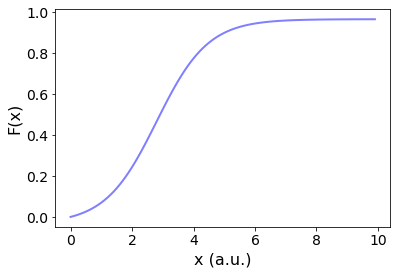

In [4]:
def F(x,a,theta): 
    '''
    Population activation function.

    Expecxts:
    x     : the population input
    a     : the gain of the function
    theta : the threshold of the function
    
    Returns:
    the population activation response F(x) for input x
    '''
    # add the expression of f = F(x)
    f = (1+np.exp(-a*(x-theta)))**-1 - (1+np.exp(a*theta))**-1

    return f

pars = default_parsE() # get default parameters
x = np.arange(0,10,.1) # set the range of input
fig1=plt.figure()
plt.plot(x, F(x,pars['a_E'],pars['theta_E']), 'b', alpha=0.5)
plt.xlabel('x (a.u.)')
plt.ylabel('F(x)')
plt.show()

### Parameter Exploration
Here's an interactive demo that shows how the F-I curves changes for different values of the gain and threshold


**Remember to enable the demo by running the cell.**

In [5]:
#@title F-I curve Explorer
def plot_FI(a, theta):
    '''
    Population activation function.

    Expecxts:
    a     : the gain of the function
    theta : the threshold of the function
    
    Returns:
    plot the F-I curve with give parameters
    '''
    # set the range of input
    x = np.arange(0,10,.1)
    plt.figure()
    plt.plot(x, F(x, a, theta), 'k')
    plt.xlabel('x (a.u.)', fontsize=14.)
    plt.ylabel('F(x)', fontsize=14.)
    plt.show()

_ = widgets.interact(plot_FI, a = (0.3, 3., 0.3), \
                              theta = (2., 4., 0.2)) 

interactive(children=(FloatSlider(value=1.5, description='a', max=3.0, min=0.3, step=0.3), FloatSlider(value=3…

## Simulation scheme of E dynamics

Because $F(\cdot)$ is a nonlinear function, the exact solution of Equation $1$  can not be determined via algebraic methods. Therefore, numerical methods are used to approximate the solutions. The derivatives of Equation. (1) can be approximated by the Euler scheme on the time-grid of stepsize $\Delta t$ as

\begin{align}
&\frac{dE}{dt} \approx \frac{E[k+1]-E[k]}{\Delta t} 
\end{align}
where $E[k] = E(k\Delta t)$. 

Thus,

$$\Delta E[k] = \frac{\Delta t}{\tau_E}[-E[k] + F(w_{EE}E[k] + I^{\text{ext}}_E[k];a_E,\theta_E)]$$


One can obtain the updating process of Equation. (1)

$$E[k+1] = E[k] + \Delta E[k]$$

**_Please excute the below cell to enable the WC simulator_**

In [6]:
#@title WC E population simulator: `simulate_wcE`
def simulate_wcE(pars):
    
    '''
    Simulate the Wilson-Cowan equations 
    
    Expects:
    pars : Parameter dictionary
    
    Returns:
    E : Activity of excitatory population (array)
    '''
    
    # Set parameters
    tau_E, a_E, theta_E = pars['tau_E'], pars['a_E'], pars['theta_E']
    wEE = pars['wEE']
    I_ext_E = pars['I_ext_E']
    E_init = pars['E_init']      
    dt, range_t = pars['dt'], pars['range_t'] 
    Lt = range_t.size 
        
    # Initialize activity
    E = np.zeros(Lt)
    E[0] = E_init
    I_ext_E = I_ext_E*np.ones(Lt)

    # Update the E activity 
    for k in range(Lt-1):
        dE = dt/tau_E * (-E[k] + F(wEE*E[k]+I_ext_E[k], a_E, theta_E))
        E[k+1] = E[k] + dE
        
    return E

print(help(simulate_wcE))


Help on function simulate_wcE in module __main__:

simulate_wcE(pars)
    Simulate the Wilson-Cowan equations 
    
    Expects:
    pars : Parameter dictionary
    
    Returns:
    E : Activity of excitatory population (array)

None


#### Parameter Exploration

Note that $w_{EE}=0$ in the defualt setting, e.g., Equation. (1) becomes a purely feedforward system. Try to explore how your E activity involves with different $I_{E}^{\text{ext}}$ and $\tau_E$ values, and investigate the relationship between $F(I_{E}^{\text{ext}}; a_E, \theta_E)$ and the steady value of E.

In [7]:
#@title Mean-field model Explorer

# get default parameters
pars = default_parsE(T=20.)

def Myplot_E_diffI_difftau(I_ext, tau_E):
    # set external input and time constant
    pars['I_ext_E'] = I_ext
    pars['tau_E'] = tau_E

    # simulation
    E = simulate_wcE(pars)

    E_ana = pars['E_init'] + (F(I_ext,pars['a_E'],pars['theta_E'])-pars['E_init'])*\
    (1.-np.exp(-pars['range_t']/pars['tau_E']))

    # plot
    plt.figure()
    plt.plot(pars['range_t'], E, 'b', label='E(t)', alpha=0.5, zorder=1)
    plt.plot(pars['range_t'], E_ana, 'b--', lw=5, dashes=(2,2),\
                 label=r'$E_{\mathrm{ana}}$(t)', zorder=2)
    plt.plot(pars['range_t'], F(I_ext,pars['a_E'],pars['theta_E'])\
                *np.ones(pars['range_t'].size), 'k--', label=r'$F(I_E^{\mathrm{ext}})$')
    plt.xlabel('t (ms)', fontsize=16.)
    plt.ylabel('E activity', fontsize=16.)
    plt.legend(loc='best', fontsize=14.)
    plt.show()

_ = widgets.interact(Myplot_E_diffI_difftau, I_ext = (0.0, 10., 1.),\
                                             tau_E = (1., 5., 0.2)) 

## preparation for storing the ouput
#E_steady = []
#F_value = []
#
#for I_ext in np.arange(0.0, 10.1, 1.):
#    # set external input into E
#    pars['I_ext_E'] = I_ext
#
#    # simulation
#    E = simulate_wcE(pars)
#
#    E_steady.append(E[-1]) # store the last value of E
#    F_value.append(F(I_ext,pars['a_E'],pars['theta_E']))
#
#E_steady = np.array(E_steady)
#F_value = np.array(F_value)
#
#plt.figure(figsize=(4, 4))
#plt.plot(E_steady - F_value, 'k', lw=2., label='Simulation')
##plt.plot([0, 1], [0, 1], 'k--', label='y=x')
##plt.legend(loc='best', fontsize=12.)
#plt.xlabel('Steady E', fontsize=14.)
#plt.ylabel(r'$F(I_E^{\mathrm{ext}})$', fontsize=14.)
#plt.show()

interactive(children=(FloatSlider(value=5.0, description='I_ext', max=10.0, step=1.0), FloatSlider(value=3.0, …

### Think and try to answer
In the above we numerically solved the dynamics of a system in which excitatory neurons are connected to excitatory neurons and we are driving this system with positive input. Yet, the system decays to zero or reaches a fixed non-zero value. 
- Why the system does not explode or what keeps the system in a state of finite output? 
- Which parameter would you like to change to increase the maximum value of the response? 

## Fixed point of the E system
As you varied the two parameters, you noticed that first the system ouput changes but with time the output reaches its maximum/minimum values and does not change. This is called the **steady state** of the system or the **fixed point**. Essentially in the steady states the derivative of the activity ($E$) is zero. 

So we can find that the steady state of the Equation $1$ by setting $\displaystyle{\frac{dE}{dt}=0}$ i.e.

$$E_{\text{steady}} = F(w_{EE}E_{\text{steady}} + I^{\text{ext}}_E;a_E,\theta_E) = 0, \qquad (3)$$

This means that when $\displaystyle{\frac{dE}{dt}=0}$ the system will stay at this steady state unless extra perturbation. Therefore, we can obtain the steady state of our excitatory population by solving Equation $3$.

From above figure, it can be shown that $\tau_E$ determines the how fast  the activity converge to the steady state from the initial value. 

In addtion, in the specific case of $w_{EE}=0$, we can clear learn the effect of $\tau_E$ from the analytical solution of Equation $1$ (i.e., the thick blue dashed line): 

$$\displaystyle{E(t) = \big{[}F(I^{\text{ext}}_E;a_E,\theta_E) -E(t=0)\big{]} (1-\text{e}^{-\frac{t}{\tau_E}})} + E(t=0)$$ \\

The solution of Equation $3$ is **fixed point**, which satisfies $\displaystyle{\frac{dE}{dt}=0}$ (determines steady state). We can calculate the fixed point with the `scipy.optimize.root` function <font size=2><font color='gray'>_(note that at the very beginning, we "import scipy.optimize as opt" )_</font></font>.

\\

Please excute the cell below for the fuction `my_fpE`, `check_fpE` and `plot_fpE`

In [8]:
#@title Function of calculating the fixed point
def my_fpE(pars, E_init):

    # get the parameters
    a_E, theta_E = pars['a_E'], pars['theta_E']
    wEE = pars['wEE']
    I_ext_E = pars['I_ext_E']
    
    # define the right hand of E dynamics
    def my_WCr(x):
        E = x[0]
        dEdt=(-E + F(wEE*E+I_ext_E,a_E,theta_E))
        y = np.array(dEdt)
        
        return y
    
    x0 = np.array(E_init)
    x_fp = opt.root(my_WCr, x0).x
    
    return x_fp

def check_fpE(pars, x_fp):

    a_E, theta_E = pars['a_E'], pars['theta_E']
    wEE = pars['wEE']
    I_ext_E = pars['I_ext_E']

    # calculate Equation(3)
    y = x_fp- F(wEE*x_fp+I_ext_E, a_E, theta_E)

    #check it np.abs(y)<1e-4

    return np.abs(y)<1e-4

def plot_fpE(pars, x_fp, mycolor):
    
    wEE = pars['wEE']
    I_ext_E = pars['I_ext_E']

    plt.plot(wEE*x_fp+I_ext_E, x_fp, 'o', color=mycolor)


#### Visualization of the fixed point

Sometimes it may be too difficult to analytically solve the $\displaystyle{\frac{dE}{dt}=0}$ to find out the fixed points. In such cases it is very useful to just plot the equation $\displaystyle{\frac{dE}{dt}=0}$ as a function of $E$. Zero crossing of the function are the fixed points. 

Here, let's set $w_{EE}=5.0$ and $I^{\text{ext}}_E=0.5$. In addition, $\displaystyle{\frac{dE}{dt}}$ can be calculated as Equation $1$. Plot the line, and check how many fixed points there. 

Try to find the fixed point by the given function `my_fpE(pars, E_init)` with different initial value $E_{\text{init}}$. Is the fixed point you get the intersection of the lines? You can use the given function `check_fpE(pars, x_fp)` to verify that.

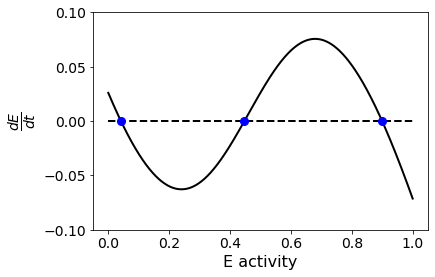

In [9]:
pars = default_parsE() # get default parameters

#set your external input and wEE
pars['I_ext_E'] = 0.5
pars['wEE'] = 5.0
 
# give E_grid
E_grid = np.linspace(0, 1., 1000)

fig3 = plt.figure()
#Calculate dEdt
dEdt = -E_grid + F(pars['wEE']*E_grid+pars['I_ext_E'], pars['a_E'],  pars['theta_E'])
plt.plot(E_grid, dEdt, 'k')
plt.plot(E_grid, 0.*E_grid, 'k--')
plt.xlabel('E activity')
plt.ylabel(r'$\frac{dE}{dt}$', fontsize=20)
plt.ylim(-0.1, 0.1)

#Calculate the fixed point with your initial value
x_fp_1 = my_fpE(pars, 0.)
plt.plot(x_fp_1, 0, 'bo')

x_fp_2 = my_fpE(pars, 0.4)
plt.plot(x_fp_2, 0, 'bo')

x_fp_3 = my_fpE(pars, 0.9)
plt.plot(x_fp_3, 0, 'bo')
plt.show()

#### Parameter Exploration

Like last time, you can now explore how the above two lines behaves when the recurrent coupling $w_{\text{EE}}$ and the external input $I_E^{\text{ext}}$ have different values.

In [10]:
#@title Fixed point Explorer

def plot_intersection_E(wEE, I_ext_E):
    #set your parameters
    pars['wEE'] = wEE
    pars['I_ext_E'] = I_ext_E

    #note that wEE !=0
    if wEE>0:
      # find fixed point
      x_fp_1 = my_fpE(pars, 0.)
      x_fp_2 = my_fpE(pars, 0.4)
      x_fp_3 = my_fpE(pars, 0.9)

      plt.figure()
      E_grid = np.linspace(0, 1., 1000)
      dEdt = -E_grid + F(wEE*E_grid+I_ext_E, pars['a_E'],  pars['theta_E'])

      plt.plot(E_grid, dEdt, 'k')
      plt.plot(E_grid, 0.*E_grid, 'k--')
          
      if check_fpE(pars, x_fp_1):
        plt.plot(x_fp_1, 0, 'bo', ms=8)
      if check_fpE(pars, x_fp_2):
        plt.plot(x_fp_2, 0, 'bo', ms=8)
      if check_fpE(pars, x_fp_3):
        plt.plot(x_fp_3, 0, 'bo', ms=8)

      plt.xlabel('E activity', fontsize=14.)
      plt.ylabel(r'$\frac{dE}{dt}$', fontsize=18.)

      plt.show()

_ = widgets.interact(plot_intersection_E, wEE = (1., 7., 0.2), \
                                          I_ext_E = (0., 3., 0.1)) 

interactive(children=(FloatSlider(value=4.0, description='wEE', max=7.0, min=1.0, step=0.2), FloatSlider(value…

### Think and try to answer
As you change wEE or the external input, number of fixed points changes between 3 and 1. This is called bifurcation i.e. when we lose or add a new fixed point. 
What does it mean that the system has three fixed points? What can you predict about the response of the system by looking at the fixed points. 

#### Explore: initial values and trajectories

Here, let's keep $w_{EE}=5.0$ and $I^{\text{ext}}_E=0.5$, and investigate how $E(t)$ invloes with different initial values. You need to plot the trajectories of $E(t)$ with $E_{\text{init}} = 0, 0.1, 0.2,..., 0.9$

In [12]:
#@title Initial value Explorer
pars = default_parsE()
pars['wEE'] = 5.0
pars['I_ext_E'] = 0.5

def plot_E_diffEinit(E_init):
    pars['E_init'] =  E_init
    E = simulate_wcE(pars)
    
    plt.figure()
    plt.plot(pars['range_t'], E, 'b', label='E(t)')
    plt.xlabel('t (ms)', fontsize=16.)
    plt.ylabel('E activity', fontsize=16.)
    plt.show()

_ = widgets.interact(plot_E_diffEinit, E_init = (0., 1., 0.02)) 

interactive(children=(FloatSlider(value=0.5, description='E_init', max=1.0, step=0.02), Output()), _dom_classe…

### Think and try to answer
Above you observed that network steady state response depends on the initial condition. Can you relate this finidng to the fixed points we estimate in the previous cells.

## Summary:

In thin tutorial, we have investigated properties about the dynamics of the single E population:

- Effect of time constant
- Fixed point, and steady state of the system
- Linearization, and stability of a fixed point

### Think 
In the tutorial above we assumed $w_{\rm EE}> 0 $ i.e. we considered a single population of excitatory neurons. What do you think will be the behavior of a population of inhibitory neurons? 


## <font size=6, color='red'>**Optional:**</font> Understand the stability by a simple linear system

Just like the case ($w_{EE}=0$) discussed above, a linear system 
$$\frac{dx}{dt} = \lambda (x - b),$$ 
has a fixed point $x=b$, and the analytical solution as
$$x(t) = b + \big{(} x(0) - b \big{)} \text{e}^{\lambda t}.$$ 
Then, considering small perturbations around the fixed point, $x(0) = b+ \epsilon$ and $|\epsilon| \ll 1$, the stability can be regarded as how the perturbation involve with time ($\epsilon (t) = x(t) - b = \epsilon \text{e}^{\lambda t}$):

- $\lambda < 0$, $x(t)$ will still converge to $b$, the fixed point is "**stable**"

- $\lambda > 0$, $x(t)$ will leave the fixed point $b$ exponentially, the fixed point is "**unstable**" 

### Compute the stability of Equation. (1)

Next, in order to determine the stability of a fixed point $E_{\rm fp}$ in the above system, we similarly perturb Equation. (1) around $E_{\rm fp}$ as $E = E_{\rm fp} + \epsilon$. According to Equation. (1), we can obtain the following approximation for $\epsilon(t)$

\begin{align}
\tau_E \frac{d\epsilon}{dt} \approx -\epsilon + F'(w_{EE}E_{\text{fp}} + I^{\text{ext}}_E;a_E,\theta_E)\cdot w_{EE} \epsilon 
\end{align}
where $F'(\cdot)$ is the derivative. That is, $[-1+ w_{EE}F'(w_{EE}E_{\text{fp}} + I^{\text{ext}}_E;a_E,\theta_E)]/\tau_E$ determines the stability of the fixed point. This value is called the **eigenvalue** of the dynamical system.

\\

The derivative of f-I function is
\begin{align} 
\frac{dF}{dx} & = \frac{d}{dx} (1+\exp\{-a(x-\theta)\})^{-1}  \\
& = a\exp\{-a(x-\theta)\} (1+\exp\{-a(x-\theta)\})^{-2}. 
\end{align} 
Let's solve the derivatives $\displaystyle{\frac{dF}{dx}}$ in the following cell and plot them out. Then please investigate the stability of the three fixed points in the system with $w_{EE}=5.0$ and $I_E^{\text{ext}}=0.5$.

#### Compute $dF$ and Eigenvalue

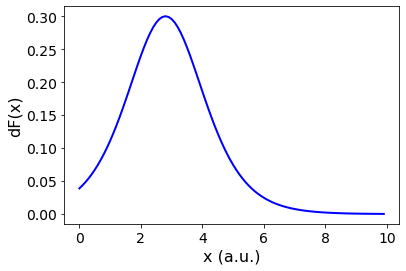

In [ ]:
def dF(x,a,theta): 
    '''
    Population activation function.

    Expecxts:
    x     : the population input
    a     : the gain of the function
    theta : the threshold of the function
    
    Returns:
    the population activation response F(x) for input x
    '''

    dFdx = a*np.exp(-a*(x-theta))*(1+np.exp(-a*(x-theta)))**-2

    return dFdx

# get default parameters
pars = default_parsE()

# set the range of input
x = np.arange(0,10,.1)

# plot figure
fig6 = plt.figure()
plt.plot(x, dF(x,pars['a_E'],pars['theta_E']), 'b')
plt.xlabel('x (a.u.)', fontsize=16.)
plt.ylabel('dF(x)', fontsize=16.)
plt.show()

def eig_E(pars, fp):
    
    '''
    Expects:
    pars : Parameter dictionary
    fp   : fixed point E
    
    Returns:
    eig : eigevalue of the linearized system
    '''
    
    #get the parameters
    tau_E, a_E, theta_E = pars['tau_E'], pars['a_E'], pars['theta_E']
    wEE, I_ext_E = pars['wEE'],  pars['I_ext_E']
    # fixed point
    E = fp

    eig = (-1. + wEE*dF(wEE*E + I_ext_E, a_E, theta_E)) / tau_E 

    return eig 


#### Exercise: Compute eigenvalues 

As discussed above, for the case with $w_{EE}=5.0$ and $I^{\text{ext}}_E=0.5$, we can have **three** fixed points. However, when we vary $E_{\rm init}$, we only can obtain **two** steady states. Since we have already obtained each fixed point, now let's calculate the corresponding eigevalue with our function `eig_E` defined above. Check the sign of each eigenvalue (i.e., stability of each fixed point)

In [ ]:
pars = default_parsE()
pars['wEE'] = 5.0
pars['I_ext_E'] = 0.5

x_fp_1 = my_fpE(pars, 0.0)
eig_E1 = eig_E(pars, x_fp_1)
print('Fixed point1=%.3f, Eigenvalue=%.3f' % (x_fp_1, eig_E1))

x_fp_2 = my_fpE(pars, 0.4)
eig_E2 = eig_E(pars, x_fp_2)
print('Fixed point2=%.3f, Eigenvalue=%.3f' % (x_fp_2, eig_E2))

x_fp_3 = my_fpE(pars, 0.9)
eig_E3 = eig_E(pars, x_fp_3)
print('Fixed point3=%.3f, Eigenvalue=%.3f' % (x_fp_3, eig_E3))


Fixed point1=0.042, Eigenvalue=-0.583
Fixed point2=0.447, Eigenvalue=0.498
Fixed point3=0.900, Eigenvalue=-0.626



## <font size=6, color='red'>**Optional:**</font> Noisy input drive transition between two stable states



### Ornstein-Uhlenbeck (OU) process

As discussed in several previous tutorials, the OU process is usually used to generate the noisy input into the neuron. The OU input $\eta(t)$ follows: 

$$\tau_\eta \frac{d}{dt}\eta(t) = -\eta (t) + \sigma_\eta\sqrt{2\tau_\eta}\xi(t).$$

please excute the following cell of function `my_OU(pars, sig, myseed=False)`

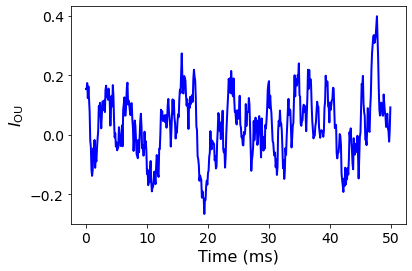

In [ ]:
#@title `my_OU(pars, sig, myseed=False)`
def my_OU(pars, sig, myseed=False):
    '''
    Expects:
    pars       : parameter dictionary
    sig        : noise amplitute
    myseed     : random seed. int or boolean
    
    Returns:
    I          : Ornstein-Uhlenbeck input current
    '''
    
    # Retrieve simulation parameters
    dt, range_t = pars['dt'], pars['range_t']
    Lt = range_t.size
    tau_ou = pars['tau_ou'] # [ms]
    
    # set random seed
    if myseed:
        np.random.seed(seed=myseed) 
    else:
        np.random.seed()
        
    # Initialize
    noise =  np.random.randn(Lt)
    I = np.zeros(Lt)
    I[0] = noise[0] * sig
    
    #generate OU
    for it in range(Lt-1):
        I[it+1] = I[it] + dt/tau_ou*(0.-I[it]) + np.sqrt(2.*dt/tau_ou) * sig * noise[it+1]
    
    return I

pars = default_parsE(T=50)
pars['tau_ou'] = 1. #[ms]
sig_ou = 0.1
I_ou = my_OU(pars, sig=sig_ou, myseed=1998)
plt.plot(pars['range_t'], I_ou, 'b')
plt.xlabel('Time (ms)')
plt.ylabel(r'$I_{\mathrm{OU}}$');

### Exercise: Up-down transition

Noisy inputs can drive transition between stwo table states.

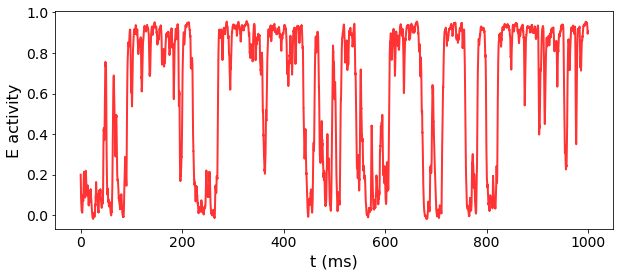

In [ ]:
pars = default_parsE(T = 1000)
pars['wEE'] = 5.0
sig_ou = 0.7
pars['tau_ou'] = 1. #[ms]
pars['I_ext_E'] = 0.56 + my_OU(pars, sig=sig_ou, myseed=2020)

E = simulate_wcE(pars)

plt.figure(figsize=(10, 4))
plt.plot(pars['range_t'], E, 'r', alpha=0.8)
plt.xlabel('t (ms)')
plt.ylabel('E activity')
plt.show()